In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import UpSampling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image


from IPython.display import display_html

2022-06-15 15:06:39.505762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Network parameters:

In [2]:
latent_size = 300
batch_size = 16
lr = 2e-4
decay = 6e-8
image_size = 64
image_dim = (image_size, image_size, 3)
image_resize = image_size // 4

## Load Data:

### [Kaggle.com](https://www.kaggle.com/datasets/splcher/animefacedataset)

In [ ]:
path = ".../images"
paths = [f"{path}/{i}" for i in os.listdir(path)][:100]
x_train = np.array([image.img_to_array(image.load_img(i, target_size=(64, 64))) / 255. for i in paths])
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=batch_size)
plt.figure(dpi=100)
plt.imshow(np.vstack([np.hstack(x_train[i: i+4]) for i in range(0, 16, 4)]))
plt.axis('off')
plt.savefig("data/img.png")
plt.show()
plt.close()

## Discriminator:

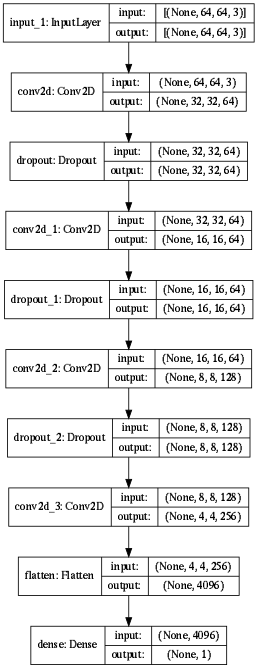

In [4]:
image = Input(image_dim)

conv1 = Conv2D(64, 5, strides=2, padding="same", activation="relu")(image) 
conv1 = Dropout(0.2)(conv1)

conv2 = Conv2D(64, 5, strides=2, padding="same", activation="relu")(conv1) 
conv2 = Dropout(0.2)(conv2)

conv3 = Conv2D(128, 5, strides=2, padding="same", activation="relu")(conv2) 
conv3 = Dropout(0.2)(conv3)

conv4 = Conv2D(256, 5, strides=2, padding="same", activation="relu")(conv3) 
conv4 = Flatten()(conv4)

prediction = Dense(1, activation="sigmoid")(conv4)

discriminator = Model(image, prediction, name="discriminator")

plot_model(discriminator, "discriminator.png", show_shapes=True, dpi=60)

## Generator model:

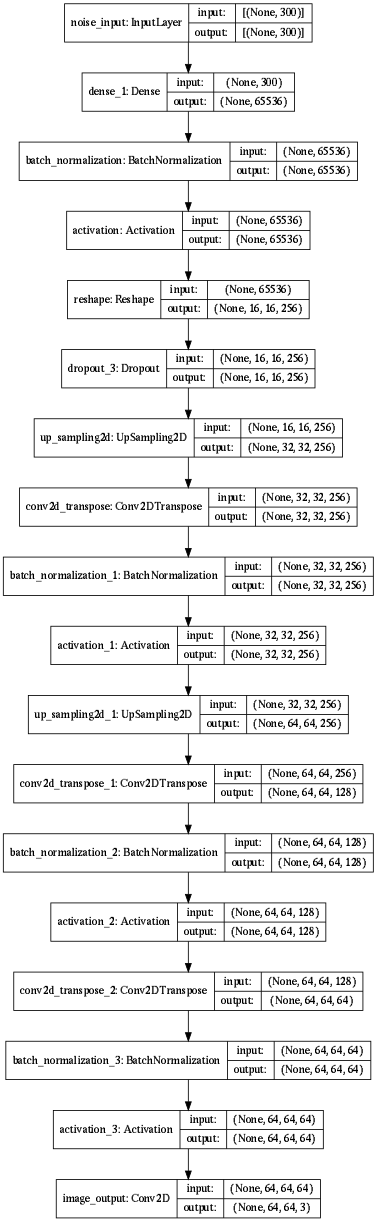

In [5]:
noise = Input((latent_size, ), name="noise_input")

dense1 = Dense(image_resize * image_resize * 256)(noise)
dense1 = BatchNormalization(momentum=0.9)(dense1)
dense1 = Activation('relu')(dense1)
dense1 = Reshape((image_resize, image_resize, 256))(dense1)
dense1 = Dropout(0.2)(dense1)

conv1 = UpSampling2D()(dense1)
conv1 = Conv2DTranspose(256, 5, padding='same', activation=None)(conv1)
conv1 = BatchNormalization(momentum=0.9)(conv1)
conv1 = Activation("relu")(conv1)

conv2 = UpSampling2D()(conv1)
conv2 = Conv2DTranspose(128, 5, padding='same', activation=None)(conv2)
conv2 = BatchNormalization(momentum=0.9)(conv2)
conv2 = Activation("relu")(conv2)

conv3 = Conv2DTranspose(64, 5, padding='same', activation=None)(conv2)
conv3 = BatchNormalization(momentum=0.9)(conv3)
conv3 = Activation("relu")(conv3)

image = Conv2D(3, 5, padding="same", activation="sigmoid", name="image_output")(conv3)

generator = Model(noise, image, name='generator')
plot_model(generator, "generator.png", show_shapes=True, dpi=60)

## Adversarial:

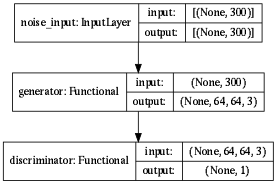

In [7]:
adversarial = tf.keras.models.Model(
    noise, 
    discriminator(generator(noise)),
    name="adversarial"
)

tf.keras.utils.plot_model(adversarial, "adversarial.png", show_shapes=True, dpi=60)

### Compile models:

In [8]:
discriminator.compile(
    loss="binary_crossentropy", 
    optimizer =tf.keras.optimizers.RMSprop(lr=lr, decay=decay),
    metrics=["accuracy"]                     
)

adversarial.compile(
    loss="binary_crossentropy", 
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5),
    metrics=["accuracy"]
)

## Training:

In [36]:
epochs = 1000
score = {"a": [], "d": []}
display_html("<h4>{}</h>".format("Start straining..."), raw=True)
for epoch in range(epochs):
    for real_images in dataset:
        noise = tf.random.normal(shape=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        mixed_images = tf.concat([fake_images, real_images], axis=0)
        discriminator_labels = tf.constant([[0.]] * batch_size + [[1]] * batch_size)
        discriminator.trainable = True
        dloss, dacc = discriminator.train_on_batch(mixed_images, discriminator_labels)

        noise = tf.random.normal(shape=[batch_size, latent_size])
        generator_labels = tf.constant([[1.]] * batch_size)

        discriminator.trainable = False
        aloss, aacc = adversarial.train_on_batch(noise, generator_labels)

        score["d"].append([dloss, dacc])
        score["a"].append([aloss, aacc])
    
    
    display_html("<p>{}</p>".format(
                 f"Epoch: {epoch + 1} "
                 f"A: loss,acc {np.mean(score['a'], axis=0).tolist()} "
                 f"D: loss,acc {np.mean(score['d'], axis=0).tolist()}"
    ), raw=True)
    
    noise = tf.random.normal(shape=[batch_size, latent_size])
    images = generator.predict(noise)
    plt.figure(dpi=100)
    plt.imshow(np.vstack([np.hstack(images[i: i+4]) for i in range(0, batch_size, 4)]))
    plt.axis('off')
    plt.savefig(f"data/images/image_epoch_{epoch+1}.png")
    plt.close()

    imgs = (Image.open(f) for f in sorted(glob.glob("data/images/image_*.png")))
    img = next(imgs)  # extract first image from iterator
    img.save(fp="images.gif", format='GIF', append_images=imgs, save_all=True, duration=500, loop=0)

Start straining...

Epoch: 1 A: loss,acc [0.0071340188252505985, 0.9971] D: loss,acc [0.28073638233604226, 0.9848]

Epoch: 2 A: loss,acc [0.0035670094126252993, 0.99855] D: loss,acc [0.17024127189597998, 0.99115]

Epoch: 3 A: loss,acc [0.0023780062750835326, 0.9990333333333333] D: loss,acc [0.13401444347883135, 0.9927666666666667]

Epoch: 4 A: loss,acc [0.0017835047063126496, 0.999275] D: loss,acc [0.10488758744186294, 0.9941125]

Epoch: 5 A: loss,acc [0.0014268037650501195, 0.99942] D: loss,acc [0.08547366910511547, 0.99512]

Epoch: 6 A: loss,acc [0.0011890031375417663, 0.9995166666666667] D: loss,acc [0.07937690602610728, 0.995675]

Epoch: 7 A: loss,acc [0.001019145546464371, 0.9995857142857143] D: loss,acc [0.06865783406815841, 0.9962071428571428]


KeyboardInterrupt



## Save Model:

In [12]:
generator.save("data/generator.h5")

**Note:** Load Trained generator

## Test model:

In [13]:
generator = load_model("data/generator.h5")

**Note:** Load Trained generator

In [ ]:
noise = tf.random.normal(shape=[batch_size, latent_size])
images = generator.predict(noise)
plt.figure(dpi=100)
plt.imshow(np.vstack([np.hstack(images[i: i+4]) for i in range(0, batch_size, 4)]))
plt.axis('off')
plt.show()